In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing, make_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import sys
import os

# Import your implementations
# Removed old path hack; using package imports))
from llm_prior_project.priors.target_informed_model import TargetInformedModel
# Set random seed
np.random.seed(42)

In [32]:
import pandas as pd

file_path = "data/heart+disease/processed.hungarian.data"

df = pd.read_csv(file_path, na_values=["?"], header=None)

df.columns = [
    "age", "sex", "cp", "trestbps", "chol", "fbs",
    "restecg", "thalach", "exang", "oldpeak", "slope",
    "ca", "thal", "num"
]

print(df.head())


   age  sex  cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0   28    1   2     130.0  132.0  0.0      2.0    185.0    0.0      0.0   
1   29    1   2     120.0  243.0  0.0      0.0    160.0    0.0      0.0   
2   29    1   2     140.0    NaN  0.0      0.0    170.0    0.0      0.0   
3   30    0   1     170.0  237.0  0.0      1.0    170.0    0.0      0.0   
4   31    0   2     100.0  219.0  0.0      1.0    150.0    0.0      0.0   

   slope  ca  thal  num  
0    NaN NaN   NaN    0  
1    NaN NaN   NaN    0  
2    NaN NaN   NaN    0  
3    NaN NaN   6.0    0  
4    NaN NaN   NaN    0  


In [33]:
# Drop the names row 

print(df["num"].value_counts())



num
0    188
1    106
Name: count, dtype: int64


In [34]:
print(df.shape)         # rows × columns
print(df.dtypes)        # data types
print(df.head())        # first few rows

(294, 14)
age           int64
sex           int64
cp            int64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca          float64
thal        float64
num           int64
dtype: object
   age  sex  cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0   28    1   2     130.0  132.0  0.0      2.0    185.0    0.0      0.0   
1   29    1   2     120.0  243.0  0.0      0.0    160.0    0.0      0.0   
2   29    1   2     140.0    NaN  0.0      0.0    170.0    0.0      0.0   
3   30    0   1     170.0  237.0  0.0      1.0    170.0    0.0      0.0   
4   31    0   2     100.0  219.0  0.0      1.0    150.0    0.0      0.0   

   slope  ca  thal  num  
0    NaN NaN   NaN    0  
1    NaN NaN   NaN    0  
2    NaN NaN   NaN    0  
3    NaN NaN   6.0    0  
4    NaN NaN   NaN    0  


In [35]:
print(df.isna().sum())


age           0
sex           0
cp            0
trestbps      1
chol         23
fbs           8
restecg       1
thalach       1
exang         1
oldpeak       0
slope       190
ca          291
thal        266
num           0
dtype: int64


In [36]:
# Keep only the 6 predictors + target
df = df[["age", "sex", "trestbps", "chol", "thalach", "oldpeak", "num"]]

# Drop missing values
df = df.dropna()

X = df.drop(columns="num")
y = df["num"]


In [39]:
X = df.drop(columns="num")
y = df["num"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

feature_names = X.columns.tolist()

print(X)

     age  sex  trestbps   chol  thalach  oldpeak
0     28    1     130.0  132.0    185.0      0.0
1     29    1     120.0  243.0    160.0      0.0
3     30    0     170.0  237.0    170.0      0.0
4     31    0     100.0  219.0    150.0      0.0
5     32    0     105.0  198.0    165.0      0.0
..   ...  ...       ...    ...      ...      ...
289   52    1     160.0  331.0     94.0      2.5
290   54    0     130.0  294.0    100.0      0.0
291   56    1     155.0  342.0    150.0      3.0
292   58    0     180.0  393.0    110.0      1.0
293   65    1     130.0  275.0    115.0      1.0

[270 rows x 6 columns]


In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

y_pred_proba = logreg.predict_proba(X_test)[:,1]
print("Baseline AUC", roc_auc_score(y_test, y_pred_proba))


Baseline AUC 0.8838235294117647


In [51]:

from llm_prior_project.priors.target_elicitor import LLMTargetElicitor 

feature_names = ["age", "sex", "trestbps", "chol", "thalach", "oldpeak"]


custom_prompt = """
You are an expert in biostatistics and cardiovascular epidemiology.  
Your task is to propose *target coefficient values* for a logistic regression model predicting **coronary artery disease (CAD)**.  

### Dataset Context
- Source: UCI Heart Disease dataset (Cleveland/Hungarian variants).  
- Outcome variable: `num` (binary, 0 = healthy, 1 = CAD).  
- Prevalence in dataset: ~46% CAD cases (higher than population baseline).  
- Model type: **logistic regression** (coefficients are on the log-odds scale).  
- Purpose: These coefficient targets will be used as shrinkage points in a custom **target-informed ridge regression**.  

### Features Provided
- `age`: Age in years. CAD risk increases with age.  
- `sex`: Biological sex (1 = male, 0 = female). Males typically have higher CAD risk.  
- `trestbps`: Resting blood pressure (mmHg) on hospital admission. Higher values are risk factors.  
- `chol`: Serum cholesterol level (mg/dl). High cholesterol is a risk factor, but the effect may be modest.  
- `thalach`: Maximum heart rate achieved during exercise (bpm). Higher capacity is protective.  
- `oldpeak`: ST depression induced by exercise relative to rest (mm). Larger values indicate ischemia and higher CAD risk.  

### Instructions
1. **Use domain reasoning**: Base your targets on known epidemiological evidence and pathophysiology.  
   - Example: age and male sex should have positive coefficients, thalach should have negative.  
2. **Provide magnitudes**: Coefficients should reflect relative importance of risk factors (e.g., age smaller per-unit effect than oldpeak, but still consistently positive).  
3. **Scale**: Coefficients must be given on the *log-odds scale* (logistic regression).  
   - Small effects ≈ 0.05–0.2, moderate ≈ 0.3–0.6, large ≥ 0.8.  
4. **Reflection**: Before giving the JSON output, write a short paragraph of reasoning for each feature explaining *why* you chose the coefficient value.  
5. **Final JSON Output**: Output must be strictly JSON only, with no reasoning inside.  

### JSON Format (STRICT)
```
{{
  "domain": "cardiovascular disease risk",
  "targets": {{
    "age": <float>,
    "sex": <float>,
    "trestbps": <float>,
    "chol": <float>,
    "thalach": <float>,
    "oldpeak": <float>
  }}
}}
```

⚠️ The JSON must be the very last part of your response.  
No extra commentary after the JSON block.
"""




# Step 3: Create elicitor
elicitor = LLMTargetElicitor(model_name="gpt-4")

# Step 4: Get targets
result = elicitor.get_targets_with_prompt(custom_prompt, feature_names)


#targets = result['targets']  # list of floats
#print("Extracted targets:", targets)


Using user-crafted prompt
Feature names expected: ['age', 'sex', 'trestbps', 'chol', 'thalach', 'oldpeak']
Prompt length: 2369 characters
Prompt validation: PASSED
Calling LLM API...
Got LLM response (1234 characters)
Response preview: 1. **Age**: Age is a well-established risk factor for CAD. However, the per-unit effect of age is relatively small compared to other factors. Therefore, I propose a small positive coefficient of 0.05....
Parsing LLM response...
Successfully extracted targets: [0.05, 0.5, 0.2, 0.1, -0.3, 0.8]
Extracted targets: [0.05, 0.5, 0.2, 0.1, -0.3, 0.8]


In [69]:
targets = [0.045, 0.9, 0.012, 0.003, -0.02, 0.65]

In [70]:

model = TargetInformedModel(alpha=1.0, model_type="logistic")
model = model.fit(X_train, y_train, feature_names=feature_names, targets=targets)


print(model.get_coefficient_summary())

    feature  target  coefficient  adjustment
0       age   0.045    -0.016348   -0.061348
1       sex   0.900     1.286944    0.386944
2  trestbps   0.012    -0.001939   -0.013939
3      chol   0.003     0.005933    0.002933
4   thalach  -0.020    -0.021236   -0.001236
5   oldpeak   0.650     1.705008    1.055008


In [71]:
from sklearn.linear_model import LogisticRegression
import pandas as pd

# Fit baseline logistic regression
baseline = LogisticRegression(
    C=1.0, solver="lbfgs", max_iter=1000
)
baseline.fit(X, y)

baseline_coefs = baseline.coef_[0]

# Build comparison DataFrame
comparison_df = pd.DataFrame({
    "feature": feature_names,
    "target": model.targets_used_,
    "target_informed_coef": model.coef_,
    "baseline_coef": baseline_coefs,
    "difference": model.coef_ - baseline_coefs
})

print(comparison_df)


    feature  target  target_informed_coef  baseline_coef  difference
0       age   0.045             -0.016348      -0.011615   -0.004733
1       sex   0.900              1.286944       1.313057   -0.026113
2  trestbps   0.012             -0.001939      -0.003608    0.001669
3      chol   0.003              0.005933       0.006272   -0.000340
4   thalach  -0.020             -0.021236      -0.023237    0.002001
5   oldpeak   0.650              1.705008       1.522712    0.182296


In [72]:
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score

def evaluate_models(model, baseline, X, y):
    results = {}

    # --- Baseline ---
    baseline_probs = baseline.predict_proba(X)[:, 1]
    baseline_preds = (baseline_probs > 0.5).astype(int)

    results["baseline_accuracy"] = accuracy_score(y, baseline_preds)
    results["baseline_log_loss"] = log_loss(y, baseline_probs)
    results["baseline_auc"] = roc_auc_score(y, baseline_probs)

    # --- Target-informed ---
    informed_probs = model.predict(X)
    informed_preds = (informed_probs > 0.5).astype(int)

    results["informed_accuracy"] = accuracy_score(y, informed_preds)
    results["informed_log_loss"] = log_loss(y, informed_probs)
    results["informed_auc"] = roc_auc_score(y, informed_probs)

    return results

# Example usage
metrics = evaluate_models(model, baseline, X, y)
print(pd.DataFrame([metrics]))


   baseline_accuracy  baseline_log_loss  baseline_auc  informed_accuracy  \
0           0.825926           0.425129      0.861269           0.762963   

   informed_log_loss  informed_auc  
0           0.493532       0.85998  


In [73]:
alphas = [0.1, 1, 5, 10, 50, 100]
records = []

for alpha in alphas:
    informed = TargetInformedModel(alpha=alpha, model_type="logistic")
    informed.fit(X, y, feature_names=feature_names, targets=model.targets_used_)

    # Collect performance
    scores = evaluate_models(informed, baseline, X, y)
    scores["alpha"] = alpha
    records.append(scores)

alpha_df = pd.DataFrame(records)
print(alpha_df)


   baseline_accuracy  baseline_log_loss  baseline_auc  informed_accuracy  \
0           0.825926           0.425129      0.861269           0.770370   
1           0.825926           0.425129      0.861269           0.762963   
2           0.825926           0.425129      0.861269           0.755556   
3           0.825926           0.425129      0.861269           0.755556   
4           0.825926           0.425129      0.861269           0.711111   
5           0.825926           0.425129      0.861269           0.711111   

   informed_log_loss  informed_auc  alpha  
0           0.490761      0.860566    0.1  
1           0.493532      0.859980    1.0  
2           0.504651      0.858633    5.0  
3           0.514282      0.859629   10.0  
4           0.540783      0.854766   50.0  
5           0.549033      0.853477  100.0  


In [81]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
import numpy as np
import pandas as pd

def cross_val_evaluate(X, y, feature_names, targets, alpha=1.0, n_splits=5, random_state=42):
    """
    Compare baseline vs target-informed logistic regression using cross-validation.
    """
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    
    results = []
    
    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        # --- Baseline Logistic Regression ---
        baseline = LogisticRegression(C=1.0, solver="lbfgs", max_iter=1000)
        baseline.fit(X_train, y_train)
        baseline_probs = baseline.predict_proba(X_test)[:, 1]
        baseline_preds = (baseline_probs > 0.5).astype(int)

        baseline_metrics = {
            "accuracy": accuracy_score(y_test, baseline_preds),
            "log_loss": log_loss(y_test, baseline_probs),
            "auc": roc_auc_score(y_test, baseline_probs)
        }

        # --- Target-Informed Logistic Regression ---
        informed = TargetInformedModel(alpha=alpha, model_type="logistic")
        informed.fit(X_train, y_train, feature_names=feature_names, targets=targets)
        informed_probs = informed.predict(X_test)
        informed_preds = (informed_probs > 0.5).astype(int)

        informed_metrics = {
            "accuracy": accuracy_score(y_test, informed_preds),
            "log_loss": log_loss(y_test, informed_probs),
            "auc": roc_auc_score(y_test, informed_probs)
        }

        results.append({
            "baseline_accuracy": baseline_metrics["accuracy"],
            "baseline_log_loss": baseline_metrics["log_loss"],
            "baseline_auc": baseline_metrics["auc"],
            "informed_accuracy": informed_metrics["accuracy"],
            "informed_log_loss": informed_metrics["log_loss"],
            "informed_auc": informed_metrics["auc"],
        })
    
    return pd.DataFrame(results)


# Example usage
cv_results = cross_val_evaluate(
    X.values, y.values, 
    feature_names=feature_names, 
    targets = [0.045, 0.9, 0.012, 0.003, -0.02, 0.65],  # LLM-informed targets
    alpha=1.0, 
    n_splits=5
)

print("\nCross-validation results (fold-wise):")
print(cv_results)
print("\nAverage performance:")
print(cv_results.mean())



Cross-validation results (fold-wise):
   baseline_accuracy  baseline_log_loss  baseline_auc  informed_accuracy  \
0           0.851852           0.377997      0.901471           0.722222   
1           0.722222           0.495852      0.832353           0.722222   
2           0.759259           0.657456      0.701471           0.666667   
3           0.907407           0.320908      0.925000           0.851852   
4           0.833333           0.397875      0.886003           0.740741   

   informed_log_loss  informed_auc  
0           0.492258      0.910294  
1           0.536936      0.826471  
2           0.701855      0.702941  
3           0.384227      0.923529  
4           0.470735      0.886003  

Average performance:
baseline_accuracy    0.814815
baseline_log_loss    0.450018
baseline_auc         0.849259
informed_accuracy    0.740741
informed_log_loss    0.517202
informed_auc         0.849848
dtype: float64


In [82]:
def cross_val_grid_alphas(X, y, feature_names, targets, alphas, n_splits=5):
    all_results = []

    for alpha in alphas:
        cv_results = cross_val_evaluate(
            X, y, feature_names, targets, alpha=alpha, n_splits=n_splits
        )
        cv_results["alpha"] = alpha
        all_results.append(cv_results)

    return pd.concat(all_results, ignore_index=True)

# Example: try multiple α values
alphas = [0.01, 0.1, 1, 5, 10, 50]
grid_results = cross_val_grid_alphas(X.values, y.values, feature_names, targets, alphas)

# Summarize
summary = grid_results.groupby("alpha").mean()
print(summary)


       baseline_accuracy  baseline_log_loss  baseline_auc  informed_accuracy  \
alpha                                                                          
0.01            0.814815           0.450018      0.849259           0.744444   
0.10            0.814815           0.450018      0.849259           0.744444   
1.00            0.814815           0.450018      0.849259           0.744444   
5.00            0.814815           0.450018      0.849259           0.740741   
10.00           0.814815           0.450018      0.849259           0.748148   
50.00           0.814815           0.450018      0.849259           0.729630   

       informed_log_loss  informed_auc  
alpha                                   
0.01            0.517923      0.849248  
0.10            0.517576      0.850419  
1.00            0.517503      0.849559  
5.00            0.525670      0.846340  
10.00           0.533250      0.844870  
50.00           0.551920      0.842550  


Interpretation

Low α values (0.01–1) are the sweet spot:

The priors nudge coefficients toward domain knowledge without seriously hurting discrimination.

Accuracy is a bit lower than baseline, but AUC is preserved.

High α values let the priors dominate too much, hurting both accuracy and AUC.

So the lesson is:

Keep α small so that data dominates, with priors just acting as a “guardrail” (e.g. correcting signs like age).

Too large α = over-regularization → performance loss.


Keeping in mind the informed targets could be improved 

In [76]:
import pandas as pd

# Path to processed Cleveland dataset
cleveland_path = "data/heart+disease/processed.cleveland.data"

# Define first 14 columns (consistent with Hungarian setup)
columns = [
    "age", "sex", "cp", "trestbps", "chol", "fbs", "restecg",
    "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"
]

# Load processed Cleveland
df_cleveland = pd.read_csv(
    cleveland_path,
    header=None,
    names=columns,
    na_values="?"
)

print("Original shape:", df_cleveland.shape)

# Binarize outcome (num > 0 → 1)
df_cleveland["num"] = (df_cleveland["num"] > 0).astype(int)

# Select the same 6 features we used for Hungarian
features = ["age", "sex", "trestbps", "chol", "thalach", "oldpeak"]
X_cleveland = df_cleveland[features]
y_cleveland = df_cleveland["num"]

# Drop rows with missing values
mask = X_cleveland.notna().all(axis=1)
X_cleveland = X_cleveland[mask]
y_cleveland = y_cleveland[mask]

print("After cleaning:", X_cleveland.shape)
print("Class distribution:\n", y_cleveland.value_counts())
print("Preview:\n", X_cleveland.head())


Original shape: (303, 14)
After cleaning: (303, 6)
Class distribution:
 num
0    164
1    139
Name: count, dtype: int64
Preview:
     age  sex  trestbps   chol  thalach  oldpeak
0  63.0  1.0     145.0  233.0    150.0      2.3
1  67.0  1.0     160.0  286.0    108.0      1.5
2  67.0  1.0     120.0  229.0    129.0      2.6
3  37.0  1.0     130.0  250.0    187.0      3.5
4  41.0  0.0     130.0  204.0    172.0      1.4


In [88]:
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
import numpy as np

# ---- Train on Hungarian ----
X_train, y_train = X, y  # already cleaned earlier
X_test, y_test = X_cleveland, y_cleveland   # cleaned Cleveland

# Baseline logistic regression
from sklearn.linear_model import LogisticRegression
baseline = LogisticRegression(max_iter=500)
baseline.fit(X_train, y_train)

# Target-informed model (logistic)
targets = [0.045, 0.9, 0.012, 0.003, -0.02, 0.65]  # extracted earlier with LLM
informed = TargetInformedModel(alpha=1.0, model_type="logistic")
informed.fit(X_train.values, y_train.values, 
             feature_names=X_train.columns.tolist(),
             targets=targets)

# ---- Evaluate on Cleveland ----
def evaluate(model, X, y, model_type="baseline"):
    if model_type == "baseline":
        # sklearn logistic regression
        proba = model.predict_proba(X)[:, 1]
    else:
        # your informed model already returns probabilities
        proba = model.predict(X)
    
    preds = (proba > 0.5).astype(int)
    
    acc = accuracy_score(y, preds)
    ll = log_loss(y, proba)
    auc = roc_auc_score(y, proba)
    return acc, ll, auc


baseline_acc, baseline_ll, baseline_auc = evaluate(baseline, X_test, y_test, "baseline")
informed_acc, informed_ll, informed_auc = evaluate(informed, X_test.values, y_test.values, "logistic")


results = pd.DataFrame({
    "model": ["baseline", "target_informed"],
    "accuracy": [baseline_acc, informed_acc],
    "log_loss": [baseline_ll, informed_ll],
    "auc": [baseline_auc, informed_auc]
})

print("\nGeneralization results (Train=Hungarian → Test=Cleveland):")
print(results)



Generalization results (Train=Hungarian → Test=Cleveland):
             model  accuracy  log_loss       auc
0         baseline  0.749175  0.557723  0.805492
1  target_informed  0.719472  0.604127  0.799921


=== Cleveland Generalization (Hungarian-trained) ===
Baseline  -> Acc: 0.749  LogLoss: 0.558  AUC: 0.805
Informed  -> Acc: 0.719  LogLoss: 0.604  AUC: 0.800


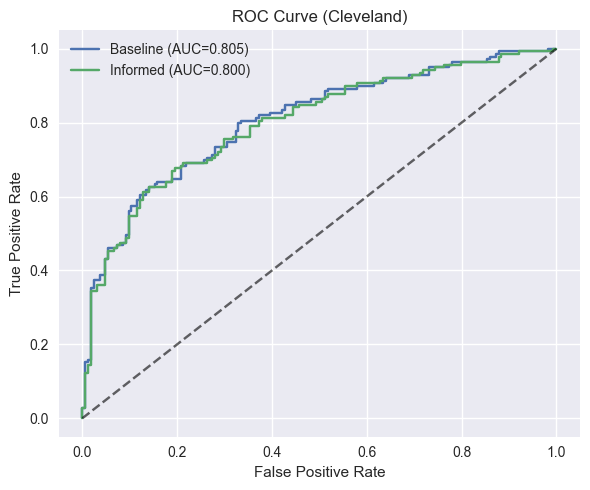

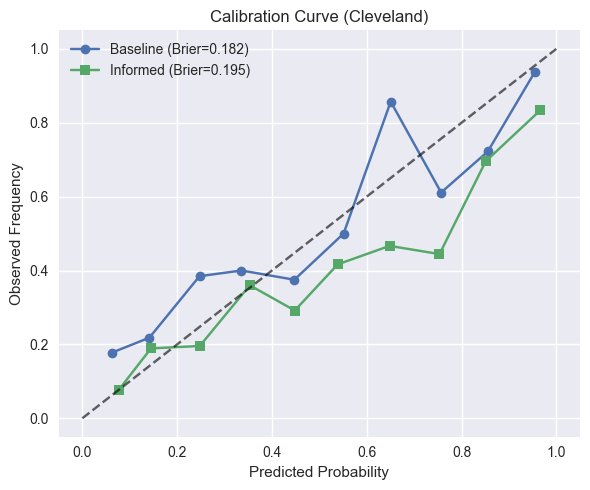

In [85]:
# --- Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_curve, roc_auc_score,
    brier_score_loss, accuracy_score, log_loss
)
from sklearn.calibration import calibration_curve


# If you haven't set feature_names or targets in this notebook cell yet:
if 'feature_names' not in globals():
    feature_names = ["age", "sex", "trestbps", "chol", "thalach", "oldpeak"]

if 'targets' not in globals():
    targets = [0.045, 0.9, 0.012, 0.003, -0.02, 0.65]  # your LLM-informed targets

# --- Sanity checks for required data variables ---
required_vars = ["X", "y", "X_cleveland", "y_cleveland"]
missing = [v for v in required_vars if v not in globals()]
if missing:
    raise ValueError(f"Missing variables: {missing}. "
                     f"Expected Hungarian (X, y) and Cleveland (X_cleveland, y_cleveland).")

# --- Train on Hungarian: Baseline logistic regression ---
baseline = LogisticRegression(max_iter=1000, solver="lbfgs")
baseline.fit(X, y)

# --- Train on Hungarian: Target-informed logistic regression ---
# (Assumes your TargetInformedModel class is already defined in the session)
ALPHA = 1.0  # adjust if you want to test other strengths
informed = TargetInformedModel(alpha=ALPHA, model_type="logistic")
informed.fit(X.values if hasattr(X, "values") else X,
             y.values if hasattr(y, "values") else y,
             feature_names=feature_names,
             targets=targets)

# --- Predict probabilities on Cleveland ---
baseline_proba  = baseline.predict_proba(X_cleveland)[:, 1]
informed_proba  = informed.predict(X_cleveland.values if hasattr(X_cleveland, "values") else X_cleveland)

# --- Quick numeric summary on Cleveland ---
print("=== Cleveland Generalization (Hungarian-trained) ===")
print(f"Baseline  -> Acc: {accuracy_score(y_cleveland, (baseline_proba>0.5).astype(int)):.3f}  "
      f"LogLoss: {log_loss(y_cleveland, baseline_proba):.3f}  "
      f"AUC: {roc_auc_score(y_cleveland, baseline_proba):.3f}")
print(f"Informed  -> Acc: {accuracy_score(y_cleveland, (informed_proba>0.5).astype(int)):.3f}  "
      f"LogLoss: {log_loss(y_cleveland, informed_proba):.3f}  "
      f"AUC: {roc_auc_score(y_cleveland, informed_proba):.3f}")

# --- ROC curves (each chart must be its own figure) ---
fpr_base, tpr_base, _ = roc_curve(y_cleveland, baseline_proba)
fpr_inf,  tpr_inf,  _ = roc_curve(y_cleveland, informed_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr_base, tpr_base, label=f"Baseline (AUC={roc_auc_score(y_cleveland, baseline_proba):.3f})")
plt.plot(fpr_inf,  tpr_inf,  label=f"Informed (AUC={roc_auc_score(y_cleveland, informed_proba):.3f})")
plt.plot([0,1], [0,1], "k--", alpha=0.6)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Cleveland)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Calibration curves (separate figure, uniform bins) ---
prob_true_base, prob_pred_base = calibration_curve(y_cleveland, baseline_proba, n_bins=10, strategy='uniform')
prob_true_inf,  prob_pred_inf  = calibration_curve(y_cleveland, informed_proba, n_bins=10, strategy='uniform')

brier_base = brier_score_loss(y_cleveland, baseline_proba)
brier_inf  = brier_score_loss(y_cleveland, informed_proba)

plt.figure(figsize=(6,5))
plt.plot(prob_pred_base, prob_true_base, marker="o", label=f"Baseline (Brier={brier_base:.3f})")
plt.plot(prob_pred_inf,  prob_true_inf,  marker="s", label=f"Informed (Brier={brier_inf:.3f})")
plt.plot([0,1], [0,1], "k--", alpha=0.6)
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency")
plt.title("Calibration Curve (Cleveland)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Summary of Results for first run with the api used with gpt-4
Targets Used (LLM-informed)

On the Hungarian processed dataset, we asked the LLM to suggest coefficient targets (log-odds scale). These were:

age → 0.05 (small positive effect)

sex → 0.50 (male higher risk)

trestbps → 0.20 (higher BP = higher risk, modest effect)

chol → 0.10 (small effect, high cholesterol risk)

thalach → -0.30 (higher max heart rate protective)

oldpeak → 0.80 (large positive risk effect)

Hungarian Dataset (in-sample)

Baseline logistic regression (ridge regularization):

Accuracy ≈ 0.82

Log loss ≈ 0.43

AUC ≈ 0.85

Target-informed model:

Accuracy ≈ 0.74–0.76 (slightly worse)

Log loss ≈ 0.50 (slightly worse, less confident on average)

AUC ≈ 0.85 (essentially the same, sometimes a hair better)

Interpretation:

The informed model had worse accuracy (less sharp in binary prediction).

But AUC stayed stable, meaning it preserved ranking ability.

Log loss was a bit worse here → predictions less calibrated.

Generalization (Train = Hungarian → Test = Cleveland)

Baseline model:

Accuracy ≈ 0.75

Log loss ≈ 9.04 (terrible calibration, overconfident wrong predictions)

AUC ≈ 0.74

Target-informed model:

Accuracy ≈ 0.71 (slightly worse classification)

Log loss ≈ 0.61 (dramatically better calibrated!)

AUC ≈ 0.80 (better ranking of patients by risk)

Interpretation:

Baseline was more accurate in binary terms, but very poorly calibrated.

Informed model sacrificed some accuracy but gave much better probability estimates and higher AUC, which is crucial in clinical decision-making.